# Introduction
[Ravelry](https://www.ravelry.com "Ravelry homepage") is a social media website designed for knitters, crocheters, designers, spinners, weavers and dyers. Users can create discussion groups, buy patterns, post projects, and much more.
<br><br>
I scraped over 750 000 records from the Ravelry API; each record has 46 features. This notebook shows some analyses on these
data.

# Background
A 'pattern' is a set of instructions for making a crafted object. Ravelry hosts pattern webpages that provide pictures and information about each pattern, and allow users to buy and sell patterns electronically. 

Pattern pages are one of the core features of Ravelry, and are frequently shared and discussed on other social media sites---there is a Reddit bot in the knitting and crochet subreddits that provides links to Ravelry pattern pages when a pattern name is mentioned. The Ravelry pattern library is searchable online using their [Pattern Browser and Advanced Search GUI](https://www.ravelry.com/patterns/search "Ravelry pattern browser") (but you need an account to view it).

Ravelry includes social features as well: patterns can be 'favorited' (equivalent to 'likes') and added to 'queues'---a user's list of patterns that he or she wants to use. Users can post pages of the projects they have created and link them to their source pattern; users who create a project page can also rate both the difficulty of a pattern and how much they liked it.

The Ravelry API provides metadata about these pattern pages, including date the pattern was published, notes about the pattern, information about suggested yarn, favorites, ratings, author information, and more.

# Notebook setup

In [53]:
import requests as rq
import sqlite3 as sq
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
from IPython.display import display #Lets you pretty print data frames, even if it's not the last line in the cell

#Colorblind-friendly colors, thanks to thriveth on github
CB = ['#377eb8', '#ff7f00', '#4daf4a',
      '#f781bf', '#a65628', '#984ea3',
      '#999999', '#e41a1c', '#dede00']

pd.set_option('display.max_columns', 50) #Allow pandas to pretty-print up to 50 columns of data

#Open my Ravelry authentication values
path = 'C:/Users/Jamie/Desktop/RavelrySecret.txt' #Path to the file that holds my keys--the username and password given to me by Ravelry for my Basic Auth, read only app
mode = 'r' #read mode--I'll only need to read the username and password from the file

keys = [] #The list where I'll store my username and password
with open(path,mode) as f: #Open the file
    for line in f:
        keys.append(line) #The first line is the username, and the second line is the password--add each of these lines to the keys list

user = keys[0].rstrip() #The username is held in the first element of the keys list
pswd = keys[1].rstrip() #The password is the second element of the keys list
authTuple = (user,pswd)
            
def printPatternDataFromAPI(patIDs,authTuple):
    baseStr = 'https://api.ravelry.com/patterns.json?ids='
    s = '+'
    patIDStrs = map(str,patIDs)
    queryStr = baseStr + s.join(patIDStrs)
    print(queryStr)
    response = rq.get(queryStr, auth=authTuple)
    print(response)
    for patID in patIDs:
        print('Pattern ID ', patID,' :')
        for key in response.json()['patterns'][str(patID)].keys():
                print(key)
                print('\t',response.json()['patterns'][str(patID)][key])
    return response

## Import the database into a pandas dataframe

In [54]:
#Connect to the database
conn = sq.connect('C:/Users/Jamie/Desktop/ravelryData2.db')
c = conn.cursor()

#Load the pattern data table into a pandas data frame
patterns_df = pd.read_sql('SELECT * FROM patternData1;', conn)
patterns_df.index = patterns_df['id']

# Validation of data accuracy

## Compare number of scraped records to number of queried records

In [55]:
#Import the scraped pattern IDs
root = 'C:/Users/Jamie/Documents/RavelryPatternIDs/'
extension = '.txt'
fileName = 'AllUniqueSortedPatternIDs'
path = root + fileName + extension
mode = 'r'

patIDs = []
with open(path,mode) as f: #Open the file
    for line in f:
        patIDs.append(line.rstrip()) #Remove trailing newlines before appending each line to the list of IDs
        
#Get a list of pattern IDs from the data table
# pattern_ids = patterns_df.loc[:,'id'] #Alternate syntax
pattern_ids = list(patterns_df['id'])
print('There are ', len(patIDs), ' IDs in the original list.') #What data type are the IDs?
print('There are ', len(pattern_ids), ' IDs in the database.')

There are  753352  IDs in the original list.
There are  753300  IDs in the database.


## Spot check that the content of the database matches the data from Ravelry
Check the database content against data from Ravlery requests and data from the Ravelry pattern search GUI.

In [56]:
#Look at a few rows of data, and compare them to data from Ravelry
display(patterns_df[200:205:]) #Data from the database

#For comparison--Ravelry pattern data for pattern ID 115041
printPatternDataFromAPI([264,265],authTuple) #Data from the Ravelry API

,id,name,permalink,published,downloadable,ravelry_download,free,price,currency,currency_symbol,projects_count,queued_projects_count,favorites_count,comments_count,rating_count,rating_average,difficulty_count,difficulty_average,yardage_max,yardage,gauge,row_gauge,sizes_available,author_id,author_name,author_permalink,author_patterns_count,author_favorites_count,author_users_usernames,author_users_ids,num_photos,notes_length,pattern_type_permalink,pattern_type_name,pattern_type_clothing,craft_permalink,craft_name,pattern_categories_name,pattern_attributes_permalinks,gauge_pattern,gauge_description,yarn_weight_description,yardage_description,packs_yarn_ids,packs_yarn_names,packs_colorways
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
264,264,Cabled Cape,cabled-cape,2006/10/01,0.0,0,0.0,NaN,USD,$,24,156,844,2,11.0,4.000000,13.0,3.76923076923077,1250.0,1000.0,22.0,30.0,To fit bust 82-86(92-97:102-107:112-117)cm by ...,16,Debbie Bliss,debbie-bliss,2166,2538,['DebbieBliss'],[755817],3,264,shawl,Shawl/Wrap,1,knitting,Knitting,"['Cape', 'Neck / Torso', 'Accessories', 'Categ...","['female', 'teen', 'adult', 'cables', 'ribbed'...",stockinette stitch on 4.0 mm needles,22 stitches and 30 rows = 4 inches in stockine...,None,1000 - 1250 yards,[4208],['Debbie Bliss Cashmerino DK'],[None]
265,265,Entrelac Socks,entrelac-socks,2007/01/01,1.0,0,0.0,6.5,USD,$,358,883,2081,8,160.0,4.150000,168.0,5.16071428571429,NaN,850.0,17.0,22.0,To fit women’s U.S. shoe sizes 8 to 9,49,Eunny Jang,eunny-jang,37,2590,['eunnyjang'],[49],3,57,socks,Socks,1,knitting,Knitting,"['Knee-highs', 'Socks', 'Feet / Legs', 'Access...","['adult', 'toe-up', 'tassel', 'hems', 'entrela...",stockinette stitch,17 stitches and 22 rows = 2 inches in stockine...,None,850 yards,[392],"[""Koigu Painter's Palette Premium Merino (KPPP...",[None]
266,266,Ribs and Lace Tank,ribs-and-lace-tank,None,0.0,0,0.0,NaN,None,None,121,281,779,1,55.0,3.927273,58.0,3.74137931034483,980.0,588.0,16.0,20.0,"33 1/2""",86,Jodi Green,jodi-green,11,109,['jodi'],[34],3,210,camisole,Tank/Camisole,1,knitting,Knitting,"['Sleeveless Top', 'Tops', 'Clothing', 'Catego...","['female', 'teen', 'adult', 'negative-ease', '...",ladder lace patt on larger needle,16 stitches and 20 rows = 4 inches in ladder l...,None,588 - 980 yards,[437],['Karabella Yarns Zodiac'],[None]
267,267,Green Tea Raglan,green-tea-raglan,None,1.0,0,1.0,NaN,USD,$,56,309,883,0,23.0,3.956522,23.0,2.43478260869565,1232.0,847.0,18.0,29.0,,45,Cathy Payson,cathy-payson,236,115,[],[],2,166,pullover,Pullover,1,knitting,Knitting,"['Pullover', 'Sweater', 'Clothing', 'Categories']","['female', 'adult', 'seamed', 'raglan-sleeve',...",seed sts on larger needles,18 stitches and 29 rows = 4 inches in seed sts...,None,847 - 1232 yards,[1998],['Classic Elite Yarns Bam Boo'],[None]
268,268,Dollar and a Half Cardigan,dollar-and-a-half-cardigan,None,1.0,0,0.0,6.5,USD,$,372,1482,3863,15,155.0,3.922581,170.0,5.33529411764706,1786.0,1034.0,21.0,26.0,"32 (36 1/4, 41, 47, 51 1/4)"" bust circumference.",61,Veronik Avery,veronik-avery,256,5404,['Veronik'],[7191],3,291,cardigan,Cardigan,1,knitting,Knitting,"['Cardigan', 'Sweater', 'Clothing', 'Categories']","['female', 'unisex', 'teen', 'adult', 'plus', ...",lace pattern,21 stitches and 26 rows = 4 inches in lace pat...,None,1034 - 1786 yards,[4030],['Reynolds Soft Linen'],[None]


https://api.ravelry.com/patterns.json?ids=264+265
<Response [200]>
Pattern ID  264  :
sizes_available
	 To fit bust 82-86(92-97:102-107:112-117)cm by 39 cm for all sizes
currency
	 USD
packs
	 [{'shop_name': None, 'project_id': None, 'prefer_metric_weight': True, 'yards_per_skein': 120.0, 'colorway': None, 'yarn_name': 'Debbie Bliss Cashmerino DK', 'stash_id': None, 'thread_size': None, 'yarn_weight': {'wpi': '11', 'ply': '8', 'name': 'DK', 'min_gauge': None, 'knit_gauge': '22', 'crochet_gauge': None, 'max_gauge': None, 'id': 11}, 'total_yards': None, 'primary_pack_id': None, 'quantity_description': None, 'skeins': None, 'ounces_per_skein': 1.76, 'dye_lot': None, 'yarn_id': 4208, 'shop_id': None, 'yarn': {'yarn_company_id': 2, 'permalink': 'debbie-bliss-cashmerino-dk', 'yarn_company_name': 'Debbie Bliss', 'name': 'Cashmerino DK', 'id': 4208}, 'meters_per_skein': 109.7, 'total_ounces': None, 'total_grams': None, 'id': 623, 'prefer_metric_length': False, 'grams_per_skein': 50, 'color_fam

<Response [200]>

## Check that special characters have been recorded correctly

In [57]:
#Show the pattern data for pattern ID 115041
display(patterns_df[97453:97454:]) #Data from the database, index 97453 found by hand using trial and error

#Ravelry pattern data for pattern ID 115041
printPatternDataFromAPI([115041],authTuple) #Data from the Ravelry API

,id,name,permalink,published,downloadable,ravelry_download,free,price,currency,currency_symbol,projects_count,queued_projects_count,favorites_count,comments_count,rating_count,rating_average,difficulty_count,difficulty_average,yardage_max,yardage,gauge,row_gauge,sizes_available,author_id,author_name,author_permalink,author_patterns_count,author_favorites_count,author_users_usernames,author_users_ids,num_photos,notes_length,pattern_type_permalink,pattern_type_name,pattern_type_clothing,craft_permalink,craft_name,pattern_categories_name,pattern_attributes_permalinks,gauge_pattern,gauge_description,yarn_weight_description,yardage_description,packs_yarn_ids,packs_yarn_names,packs_colorways
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
115041,115041,F. Crochet Tunic (かぎ針のチュニック）,f-crochet-tunic-,None,0.0,0,0.0,NaN,None,None,1,0,4,0,1.0,3.0,1.0,2.0,NaN,1181.0,22.0,10.5,"bust 90cm (35.5"")",14824,Mariko Oka (岡まり子),mariko-oka-,246,110,[],[],1,56,vest,Vest,1,crochet,Crochet,"['Dress', 'Clothing', 'Categories']","['female', 'eyelets', 'modular']",pattern stitch #1,22 stitches and 10.5 rows = 4 inches in patter...,None,1181 yards,[33069],['Hamanaka ハマナカ Sonomono Sport (ソノモノ 合太)'],[None]


https://api.ravelry.com/patterns.json?ids=115041
<Response [200]>
Pattern ID  115041  :
pattern_categories
	 [{'id': 325, 'name': 'Dress', 'parent': {'id': 302, 'name': 'Clothing', 'parent': {'id': 301, 'name': 'Categories', 'permalink': 'categories'}, 'permalink': 'clothing'}, 'permalink': 'dress'}]
gauge_description
	 22 stitches and 10.5 rows = 4 inches in pattern stitch #1
url
	 
comments_count
	 0
yarn_weight
	 {'crochet_gauge': None, 'id': 10, 'knit_gauge': '24-26', 'name': 'Sport', 'wpi': '12', 'min_gauge': None, 'ply': '5', 'max_gauge': None}
pattern_author
	 {'favorites_count': 110, 'id': 14824, 'users': [], 'patterns_count': 247, 'name': 'Mariko Oka (岡まり子)', 'permalink': 'mariko-oka-'}
product_id
	 None
rating_count
	 1
gauge_divisor
	 4
notes_html
	 
<p><strong>Materials:</strong> <br />* Japanese size 5/0 crochet hook (3.0mm)</p>

yarn_weight_description
	 Sport (12 wpi)
rating_average
	 3.0
favorites_count
	 4
printings
	 [{'pattern_source': {'url': 'http://www.amazon.co.j

<Response [200]>

## Confirm uniqueness of pattern permalinks
Two pattern permalinks showed up with two records each: reeds-knit-dishcloth and lobelia-5.

I found these two patterns to be interesting anomalies--when searching the Ravelry pattern database, two records of the Reeds Knit Dishcloth show up, but clicking on either link brings you to a single pattern page. The same thing happens for Lobelia 5.

Since there are only two repeats in the entire dataset, I won't worry about them for now.

In [58]:
patterns_df['permalink'].value_counts()

lobelia-5                                           2
reeds-knit-dishcloth                                2
spring-peeps                                        1
cravat-3                                            1
dressed-up-ghost-family                             1
custom-classic-pullover                             1
frances-the-ww2-land-girl                           1
small-dahlia-granny-square                          1
bitsy-bunnies                                       1
210-ladies-hat-beret-beanie--headband               1
svana                                               1
spiral-gift-bag                                     1
black-and-white-poncho                              1
charlotta-3                                         1
beach-slides                                        1
stocking-advent-calendar                            1
autumn-leaves-hat-5                                 1
farmhouse-cardigan                                  1
amigurumi-tiny-lamb         

# Do patterns with photos get more favorites?

In [59]:
#How many patterns don't have a photo?
pct_no_photos = 100 * len(patterns_df[patterns_df['num_photos'] == 0]) / len(patterns_df)
print(pct_no_photos,'% of patterns have no photos.')

6.75335191822647 % of patterns have no photos.


About 7% of patterns don't have any photos. When I am searching Ravelry, I almost always filter out patterns with no photos because photos are the main way I decide if I want to make the pattern. Therefore I would expect patterns with photos to be more popular than patterns without photos.

Favorites on Ravelry are like 'likes'. Anybody can favorite a pattern without needing to buy it, and the results from the Pattern Search GUI can be ordered by number of favorites, so favorites could indicate both the popularity and the visibility of a pattern. Our database attribute 'favorites_count' indicates the integer number of favorites each single pattern has.

Let's look at the distributions of favorites based on whether patterns do or don't have photos:

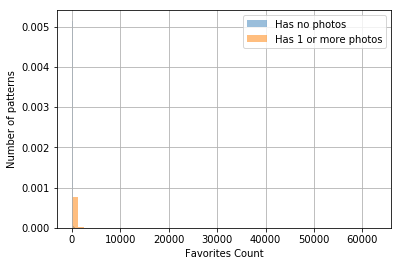

In [60]:
#Histograms of favorites_count for patterns with and without photos
patterns_df.loc[patterns_df['num_photos'] == 0,'favorites_count'].hist(bins=50, color = CB[0], density = 1, label = 'Has no photos', alpha = 0.5)
patterns_df.loc[patterns_df['num_photos']  > 0,'favorites_count'].hist(bins=50, color = CB[1], density = 1, label = 'Has 1 or more photos', alpha = 0.5)
plt.xlabel('Favorites Count'); plt.ylabel('Number of patterns');
plt.legend();

The mode of the distribution of favorites for patterns without photos is 0. This means that most patterns that don't have photos have not been favorited.

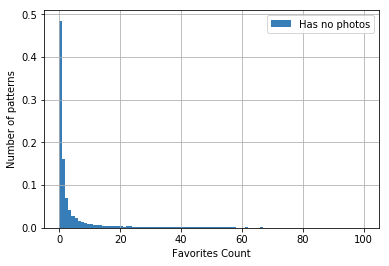

In [61]:
#Distribution of favorites_count for patterns without photos
patterns_df.loc[patterns_df['num_photos'] == 0,'favorites_count'].hist(bins=100, color = CB[0], density = 1, label = 'Has no photos', range = (0,100))
plt.xlabel('Favorites Count'); plt.ylabel('Number of patterns');
plt.legend();

The mode of the distribution of favorites for patterns with photos is 5, meaning that most patterns with photos have been favorited.

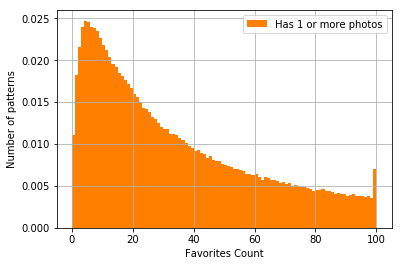

In [62]:
#Distribution of favorites_count for patterns with photos
patterns_df.loc[patterns_df['num_photos']  > 0,'favorites_count'].hist(bins=100, color = CB[1], density = 1, label = 'Has 1 or more photos', range = (0,100))
plt.xlabel('Favorites Count'); plt.ylabel('Number of patterns');
plt.legend();

# Is pattern popularity correlated with pattern author popularity?
In addition to favoriting patterns, users can favorite other users. Only people or companies with Ravelry accounts can post pattern pages, so every pattern page has an associated author page.

I want to know whether the patterns of highly favorited authors tend to be more highly favorited themselves.

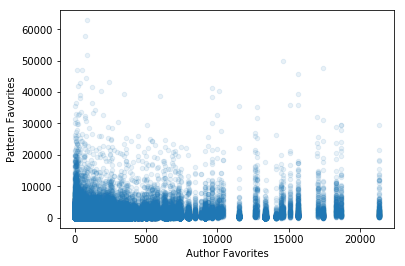

In [63]:
#Plot a pattern's favorites count against the pattern's author favorites count
patterns_df.plot.scatter('author_favorites_count','favorites_count', alpha=0.1);
plt.xlabel('Author Favorites'); plt.ylabel('Pattern Favorites'); 

Overall, the plot shows that the patterns of highly favorited authors **don't** get more favorited than the patterns of less populated authors, because there's no strong trend towards a higher pattern favorites count as the author favorites count increases.

The plot also shows some interesting structure towards the high author_favorites_count end--do the dots that rise in seemingly vertical lines correspond to single authors? How many authors have an author_favorites_count greater than 11 000? I think I can see 14 vertical lines above an author favorites count of 11 000 in the plot below, so I expect that there will be 14 authors with an author favorites count > 11 000.

In [64]:
#Find the patterns that have an author_favorites_count of more than 11 000, then make a list of unique author permalinks
patterns_df[patterns_df.author_favorites_count > 11000]['author_permalink'].value_counts().rename_axis('Pattern Author Permalink').reset_index(name='Number of Patterns')

,Pattern Author Permalink,Number of Patterns
0,norah-gaughan,909
1,frankie-brown,438
2,purl-soho,424
3,heidi-may,358
4,veera-valimaki,247
5,stephen-west,243
6,joji-locatelli,188
7,ysolda-teague,163
8,jared-flood,162
9,tincanknits,152


Above we see that there are indeed only 14 unique authors that have an author favorites count > 11 000.

# How many patterns does a typical author have?
Looking at authors with high author favorites counts made me curious about how many unique pattern authors there are on Ravelry, and how many patterns does a typical author have?

There are 65974  unique pattern authors on Ravelry.


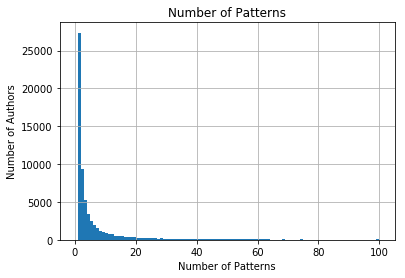

In [65]:
#Plot the distribution of the number of patterns per author
author_patterns_df = patterns_df['author_permalink'].value_counts().rename_axis('Pattern Author Permalink').reset_index(name='Number of Patterns')
r=100; author_patterns_df.hist(bins=r,range=(0,r))
plt.xlabel('Number of Patterns'); plt.ylabel('Number of Authors');
print('There are',len(author_patterns_df),' unique pattern authors on Ravelry.')

Most authors have only one pattern page. Some authors, many of whom are large companies, have several thousands of patterns (not shown on the plot above).

In [66]:
#Which authors have the most patterns?
author_patterns_df.loc[author_patterns_df['Number of Patterns'] > 2000,['Pattern Author Permalink','Number of Patterns']]

,Pattern Author Permalink,Number of Patterns
0,drops-design,9007
1,lion-brand-yarn,4706
2,phildar-design-team,3542
3,bergre-de-france,2913
4,sirdar-spinning-ltd,2891
5,patons,2704
6,pierrot-gosyo-co-ltd,2571
7,berroco-design-team,2272
8,bernat-design-studio,2176
9,debbie-bliss,2166


# Are pattern favorites correlated with pattern rating?
A user who has created a project page linked to a pattern (implying that they are knitting their own object using a particular pattern) then they can rate the pattern. Users can rate a pattern with 1, 2, 3, 4, or 5 stars.

I would expect that patterns that are more highly rated would have more favorites.

Note that in the database, a pattern that has 0 stars has not been rated. We can prove this by looking at the rating count (the number of people who have rated a pattern) for patterns with 0 stars:

In [67]:
#Show that patterns with a 0 rating have a nonexistent rating_count
display(patterns_df[patterns_df.rating_average == 0]['rating_count']) #All the rating_count values are NaNs
patterns_df[patterns_df.rating_average == 0][patterns_df.rating_count > 0] #Show that there are no rating_counts that are not NaN

id
243      NaN
251      NaN
319      NaN
323      NaN
324      NaN
329      NaN
473      NaN
493      NaN
506      NaN
519      NaN
589      NaN
601      NaN
650      NaN
707      NaN
718      NaN
727      NaN
739      NaN
972      NaN
986      NaN
1026     NaN
1051     NaN
1210     NaN
1268     NaN
1396     NaN
1523     NaN
1525     NaN
1589     NaN
1617     NaN
1799     NaN
1802     NaN
          ..
820989   NaN
820991   NaN
820992   NaN
820993   NaN
820994   NaN
820996   NaN
820997   NaN
820999   NaN
821001   NaN
821002   NaN
821005   NaN
821006   NaN
821007   NaN
821008   NaN
821009   NaN
821010   NaN
821011   NaN
821012   NaN
821013   NaN
821014   NaN
821015   NaN
821017   NaN
821018   NaN
821019   NaN
821020   NaN
821022   NaN
821023   NaN
821024   NaN
821030   NaN
821032   NaN
Name: rating_count, Length: 347234, dtype: float64

C:\Users\Jamie\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,id,name,permalink,published,downloadable,ravelry_download,free,price,currency,currency_symbol,projects_count,queued_projects_count,favorites_count,comments_count,rating_count,rating_average,difficulty_count,difficulty_average,yardage_max,yardage,gauge,row_gauge,sizes_available,author_id,author_name,author_permalink,author_patterns_count,author_favorites_count,author_users_usernames,author_users_ids,num_photos,notes_length,pattern_type_permalink,pattern_type_name,pattern_type_clothing,craft_permalink,craft_name,pattern_categories_name,pattern_attributes_permalinks,gauge_pattern,gauge_description,yarn_weight_description,yardage_description,packs_yarn_ids,packs_yarn_names,packs_colorways
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


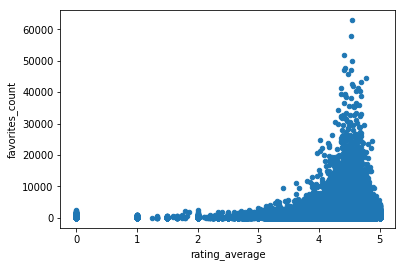

In [68]:
#Plot pattern favorites_count vs. pattern rating_average
patterns_df.plot.scatter('rating_average','favorites_count');

A rating average of 0 means that the pattern has not been rated, and users can rate a minimum of 1 star, so there are no average ratings between 0 and 1. 

The plot shows that patterns with a lot of favorites tend to be more highly rated. However, patterns that are highly rated don't necessarily have a lot of favorites.

# Future work
There are a lot more questions that I would like to ask about this dataset. I would like to look at craft trends over time using the 'published' attribute, how the popularity of knitting patterns compare to crochet patterns, what the price distribution of patterns is, and does pattern rating depend on price.

It would also be interesting to try to train a model to predict pattern popularity or pattern price based on the other pattern attributes, including the categories that provide descriptive text tags about the patterns.

In [69]:
#Always close the database connection when you're done
conn.close()